# Jointprob Hierarchical Models
+ intent
+ jointprob, prereqs - completed chapters 1, 2, 3 & 4, pitch level - novice, first time reader
+ session outline
+ Intro football models - league structure, poisson distributed goals
+ Model 1.1 - code straight from winbugs to python from [Bayesian hierarchical model for the prediction of football results (pdf) - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf) - Fail - lambda too large
+ Non-hierarchical forward simulation
    + selecting reasonable priors
+ model 1.2 - Non-hierarchical model
    + prior predictive review
+ why hierarchical (semi-pooled)?
    + start of season - promoted teams with no data
    + early season - is a team strong or has it had weak opposition
+ model 1.3 - hierarchical - fail
+ posterior geometry matters
+ model 1.4 - rebuild 1.3 with non-centred parameterization
+ model 1.5 - add coords for interpretation
+ model 1.5 appraisal to original paper results, reliability plots
+ compare model 1.2 to model 1.5
    + hierarchical model shrinkage
+ summary, repository
+ q&a

# Daniel meeting notes
+ Jointprob intro at start of talk
+ Clean Data, Notebooks, slides in jointprob repo
+ coded in pymc5

In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *

import pymc as pm
import arviz as az
import pytensor.tensor as pt
import arviz as az
from scipy.stats import poisson

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
# GOOGLE_APPLICATION_CREDENTIALS = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')
# GOOGLE_BUCKET_DIR = 'gs://' + os.environ.get('GOOGLE_BUCKET_NAME') + '/'
sys.path.append(str(PROJECT_DIR)) # script imports
from notebooks.scripts.helpers import make_1x2_calib_data, format_season_df

In [2]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 1925
LOCAL_DATA_DIR = PROJECT_DIR / 'data'
LOCAL_DATA_DIR

PosixPath('/media/david/T7/code/model-bettor/soccer-preds-001/hierarchical-soccer-model/data')

In [3]:
%load_ext watermark
%watermark --iversions

pymc      : 5.6.1
pandas    : 1.5.3
plotnine  : 0.12.2
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
numpy     : 1.23.5
matplotlib: 3.7.2
arviz     : 0.16.1
pytensor  : 2.12.3



# Data Prep
### Italy Serie A 1992-1993

In [4]:
df_orig1 = pd.read_parquet(LOCAL_DATA_DIR / 'italy_serie-a_1991-1992.parquet')

In [5]:
# def format_season_df(df_orig):
#     df = df_orig.copy()
#     # Rename teams for consistency with original paper
#     for col in ['Home', 'Away']:
#         df[col] = df[col].map({'Hellas Verona': 'Verona', 'Internazionale': 'Inter'}).fillna(df[col])
#     # Assign integer indices to alpha sorted team names
#     teams_dict = {team_name: team_num for team_name, team_num in zip(sorted(df['Home'].unique().tolist()), range(df['Home'].nunique()))}
#     for col in ['Home', 'Away']:
#         df[col.lower()[0] + 'g'] = df[col].map(teams_dict)
#     # Rename column names for consistency with original paper
#     df['yg1'] = df['h_ftgoals'] ; df['yg2'] = df['a_ftgoals']
#     # Sort the values to get an approximate match to the sorting order used in the paper
#     df = df.sort_values(by=['Date', 'Home'], ascending=[True, False]).reset_index(drop=True)
#     df['g'] = df.index
#     # lowercase col names and select columns to go forward
#     df.columns = [col.lower() for col in df.columns]
#     df = df[['g', 'home', 'away', 'hg', 'ag', 'yg1', 'yg2']]
#     # Put match outcome into df for later analysis
#     condlist = [df['yg1']>df['yg2'], df['yg1']==df['yg2'], df['yg2']>df['yg1']]
#     choicelist = ['hwin', 'draw', 'awin']
#     df['result'] = np.select(condlist, choicelist)
#     return df
df_orig1 = pd.read_parquet(LOCAL_DATA_DIR / 'italy_serie-a_1991-1992.parquet')
df1 = format_season_df(df_orig1)
df1

g      home        away  hg  ag  yg1  yg2 result
0      0    Verona        Roma  17  14  0.0  1.0   awin
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin
2      2     Lazio       Parma  10  13  1.0  1.0   draw
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin
4      4     Inter      Foggia   8   6  1.0  1.0   draw
..   ...       ...         ...  ..  ..  ...  ...    ...
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin
303  303     Inter    Atalanta   8   1  0.0  0.0   draw
304  304    Foggia       Milan   6  11  2.0  8.0   awin
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin

[306 rows x 8 columns]

### Italy Serie A 2007-2008

In [6]:
# df_orig2 = pd.read_parquet(GOOGLE_BUCKET_DIR + 'italy/serie-a.parquet')
# df_orig2.to_parquet(str(LOCAL_DATA_DIR) + 'italy_serie-a_2000-2001_2022-2023.parquet')

In [7]:
# df_orig3 = pd.read_parquet(GOOGLE_BUCKET_DIR + 'england/premier-league.parquet')
# df_orig3.to_parquet(str(LOCAL_DATA_DIR) + 'england_premier-league_2000-2001_2022-2023.parquet')
# df_orig3

In [8]:
# df_21 = df_orig2.copy()
# df_21 = df_21[df_21['season']=='2007-2008']
# df_21 = df_21.rename(columns={'h': 'Home', 'a': 'Away', 'date': 'Date'})
# df2 = format_season_df(df_21)
# df2

In [9]:
# df_orig2

# Model 1
+ Original model from paper

In [10]:
df = df1[['hg' , 'ag', 'yg1', 'yg2']]
# n_teams = df['hg'].nunique()
# home_idx = df['hg'].values
# away_idx = df['ag'].values
# home_goals = df['yg1'].values
# away_goals = df['yg2'].values
# print(f'n_teams: {n_teams}')
# print(f'home team indices (home_idx): {home_idx[0:5]}...')
# print(f'away team indices (away_idx): {away_idx[0:5]}...')
# print(f'home goals : {h_goals[0:5]}...')
# print(f'away goals: {a_goals[0:5]}...')
df.head(2)

hg  ag  yg1  yg2
0  17  14  0.0  1.0
1  12   1  1.0  0.0

In [11]:
n_teams = df['hg'].nunique()
home_idx = df['hg'].values
away_idx = df['ag'].values
home_goals = df['yg1'].values
away_goals = df['yg2'].values
print(f'n_teams: {n_teams}')
print(f'home team indices (home_idx): {home_idx[0:5]}...')
print(f'away team indices (away_idx): {away_idx[0:5]}...')
print(f'home goals : {home_goals[0:5]}...')
print(f'away goals: {away_goals[0:5]}...')

n_teams: 18
home team indices (home_idx): [17 12 10  9  8]...
away team indices (away_idx): [14  1 13  5  6]...
home goals : [0. 1. 1. 1. 1.]...
away goals: [1. 0. 1. 0. 1.]...


In [12]:
with pm.Model() as model1:
    # home advantage
    home = pm.Normal("home", mu=0, tau=0.0001)

    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=0, tau=0.0001)
    tau_att = pm.Gamma('tau_att', 0.01, 0.01)    
    mu_def = pm.Normal('mu_def', mu=0, tau=0.0001)
    tau_def = pm.Gamma('tau_def', 0.01, 0.01)

    # priors
    att_t = pm.Normal('att_t', mu=mu_att, tau=tau_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, tau=tau_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

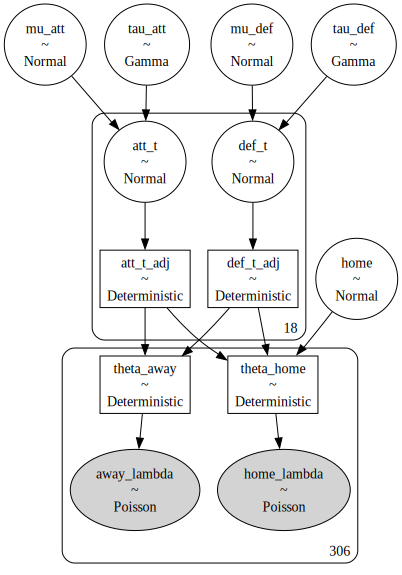

In [13]:
pm.model_to_graphviz(model1)

In [14]:
# Crashes pymc
# with model1:
#     idata = pm.sample_prior_predictive()

In [15]:
with model1:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, tau_att, mu_def, tau_def, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 254 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 150 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [16]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

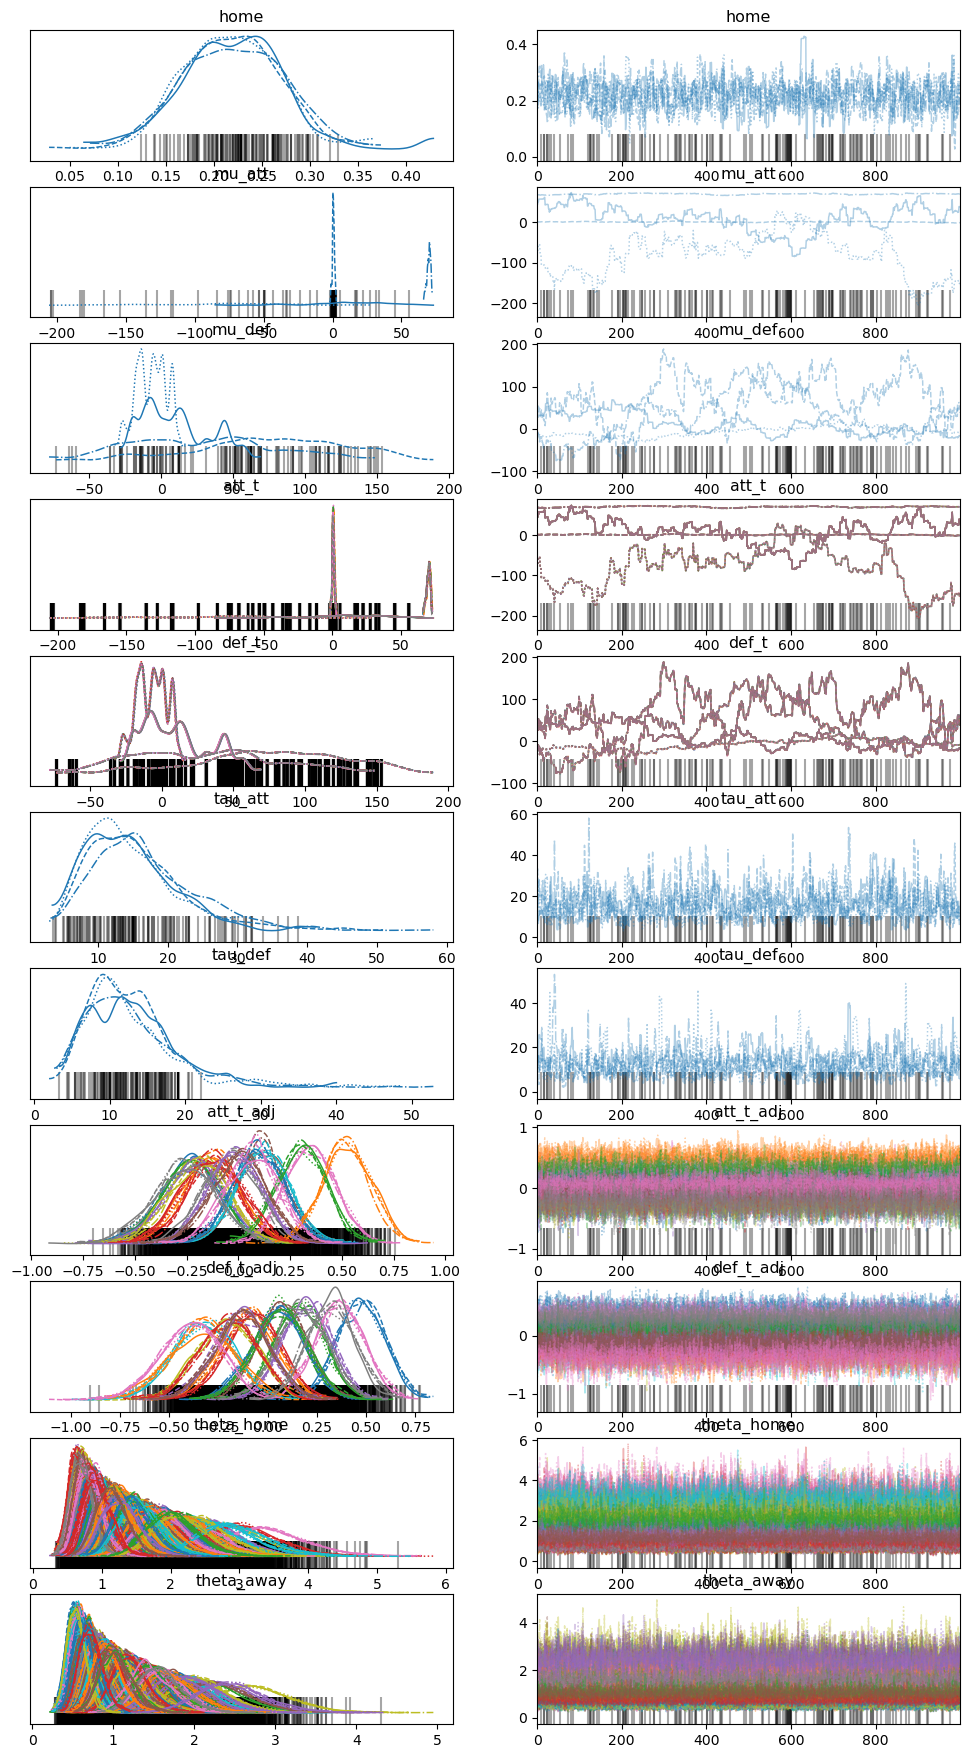

In [17]:
az.plot_trace(idata);

# Simulation
#### TODO


In [18]:
# Try a value into the formulae and review the results for realism
val = 2.0
val = 1.0
val = 0.5
val = 0.25
val = 0.1
home_adv = val
home_att = val
home_def = val
away_att = val
away_def = val
home_calc = home_adv + home_att + away_def
away_calc = away_att + home_def
print(home_calc, away_calc)
theta_home = np.exp(home_adv + home_att + away_def)
theta_away = np.exp(away_att + home_def)
print(theta_home, theta_away)

with pm.Model():
    home_scores = pm.Poisson('home_mean', theta_home)
    away_scores = pm.Poisson('away_mean', theta_away)
home_score_draws = pm.draw(home_scores, draws=1000)
away_score_draws = pm.draw(away_scores, draws=100)
home_score_draws[0:10], away_score_draws[0:10] 

0.30000000000000004 0.2
1.3498588075760032 1.2214027581601699


(array([3, 0, 1, 2, 1, 3, 1, 2, 2, 0]), array([1, 1, 0, 0, 2, 1, 2, 1, 1, 1]))

# Model 2
+ Priors adjusted based on simulation

In [19]:
with pm.Model() as model2:
    # home advantage
    home = pm.HalfNormal("home", sigma=0.25)

    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=0, sigma=0.333)
    sigma_att = pm.HalfNormal('sigma_att', sigma=0.333)    
    mu_def = pm.Normal('mu_def', mu=0, sigma=0.333)
    sigma_def = pm.HalfNormal('sigma_def', sigma=0.333)

    # priors
    att_t = pm.Normal('att_t', mu=mu_att, sigma=sigma_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, sigma=sigma_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

In [20]:
with model2:
    idata = pm.sample_prior_predictive()

Sampling: [att_t, away_lambda, def_t, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [21]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [22]:
with model2:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


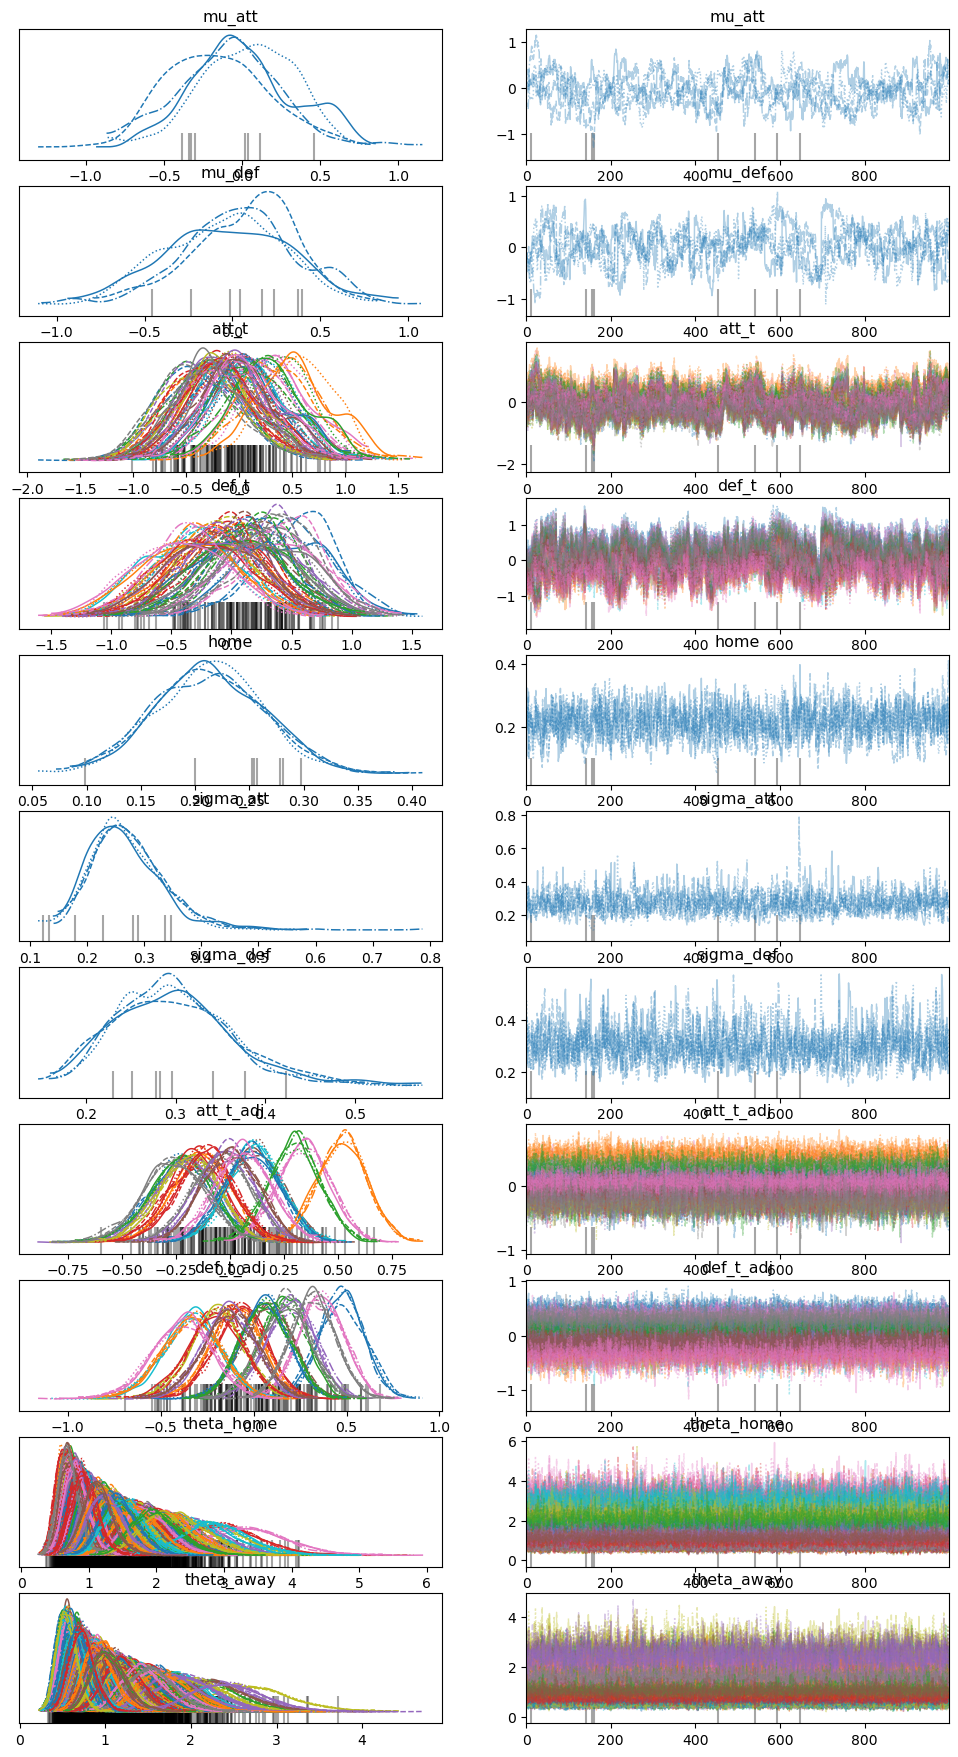

In [23]:
az.plot_trace(idata);

# Model 3
+ Non-centred parametrization

In [24]:
with pm.Model() as model3:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.25)

    # hyper-priors
    mu_att_ = pm.Normal('mu_att', mu=0, sigma=0.5)
    sigma_att = pm.HalfNormal('sigma_att', sigma=0.333)    
    mu_def_ = pm.Normal('mu_def', mu=0, sigma=0.5)
    sigma_def = pm.HalfNormal('sigma_def', sigma=0.333)

    # offsets ?
    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0, 1, shape=n_teams)

    # priors    
    att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)

    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

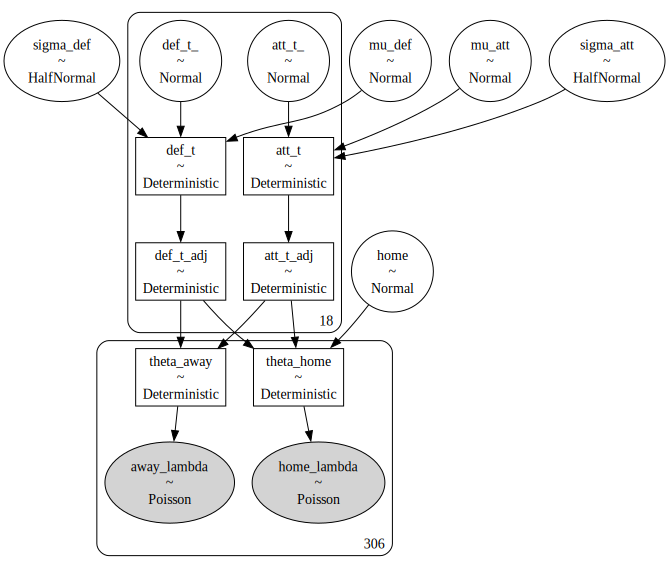

In [25]:
pm.model_to_graphviz(model3)

In [26]:
with model3:
    idata = pm.sample_prior_predictive()

Sampling: [att_t_, away_lambda, def_t_, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [27]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [28]:
with model3:
    idata = pm.sample(4000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 15 seconds.


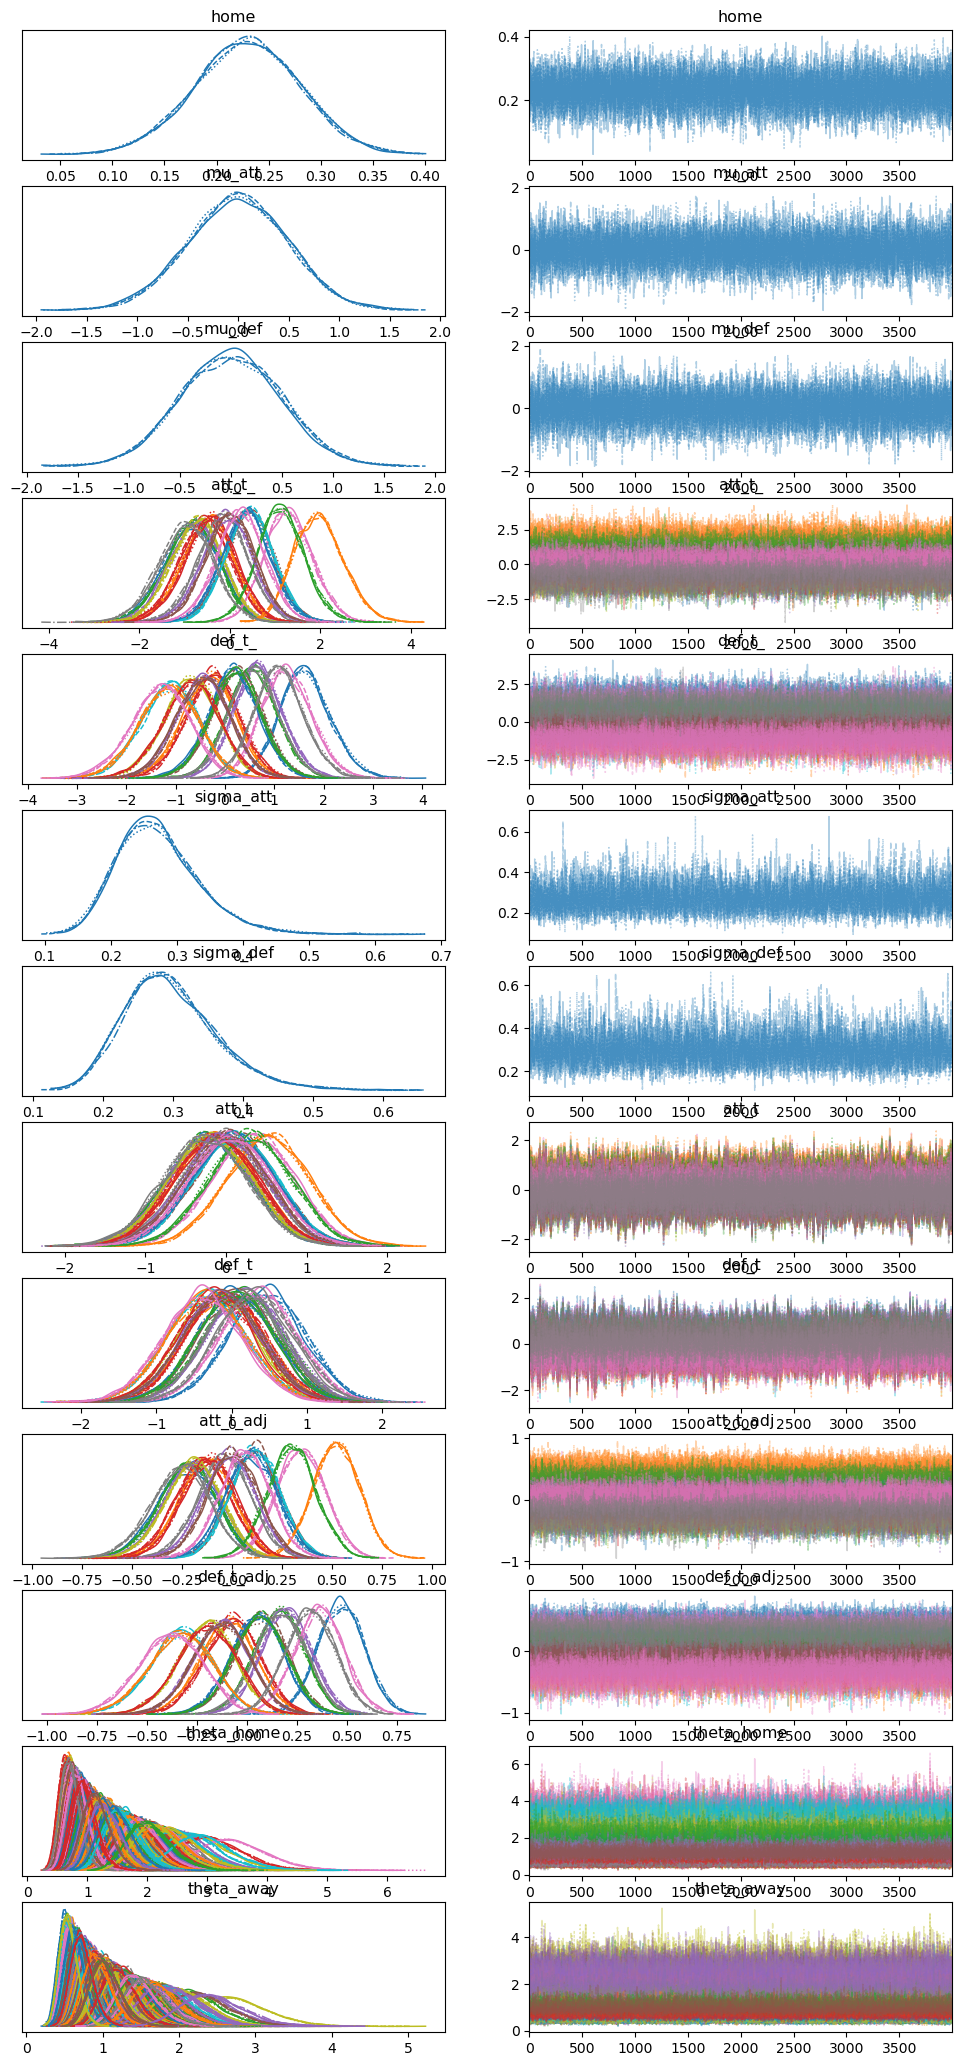

In [29]:
az.plot_trace(idata);

# Model 4
+ Non-centred parametrization
+ priors opened up
+ Add coords for easier interpretation

In [30]:
# TODO COORDS

In [31]:
with pm.Model() as model4:
    # home advantage
    home = pm.Normal("home", mu=0.0, sigma=1.0)

    # hyper-priors
    mu_att_ = pm.Normal('mu_att', mu=0, sigma=1.0)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
    mu_def_ = pm.Normal('mu_def', mu=0, sigma=1.0)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0,1, shape=n_teams)

    # priors    
    att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)
    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

In [32]:
with model4:
    idata = pm.sample_prior_predictive()

Sampling: [att_t_, away_lambda, def_t_, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [33]:
idata

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [34]:
with model4:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


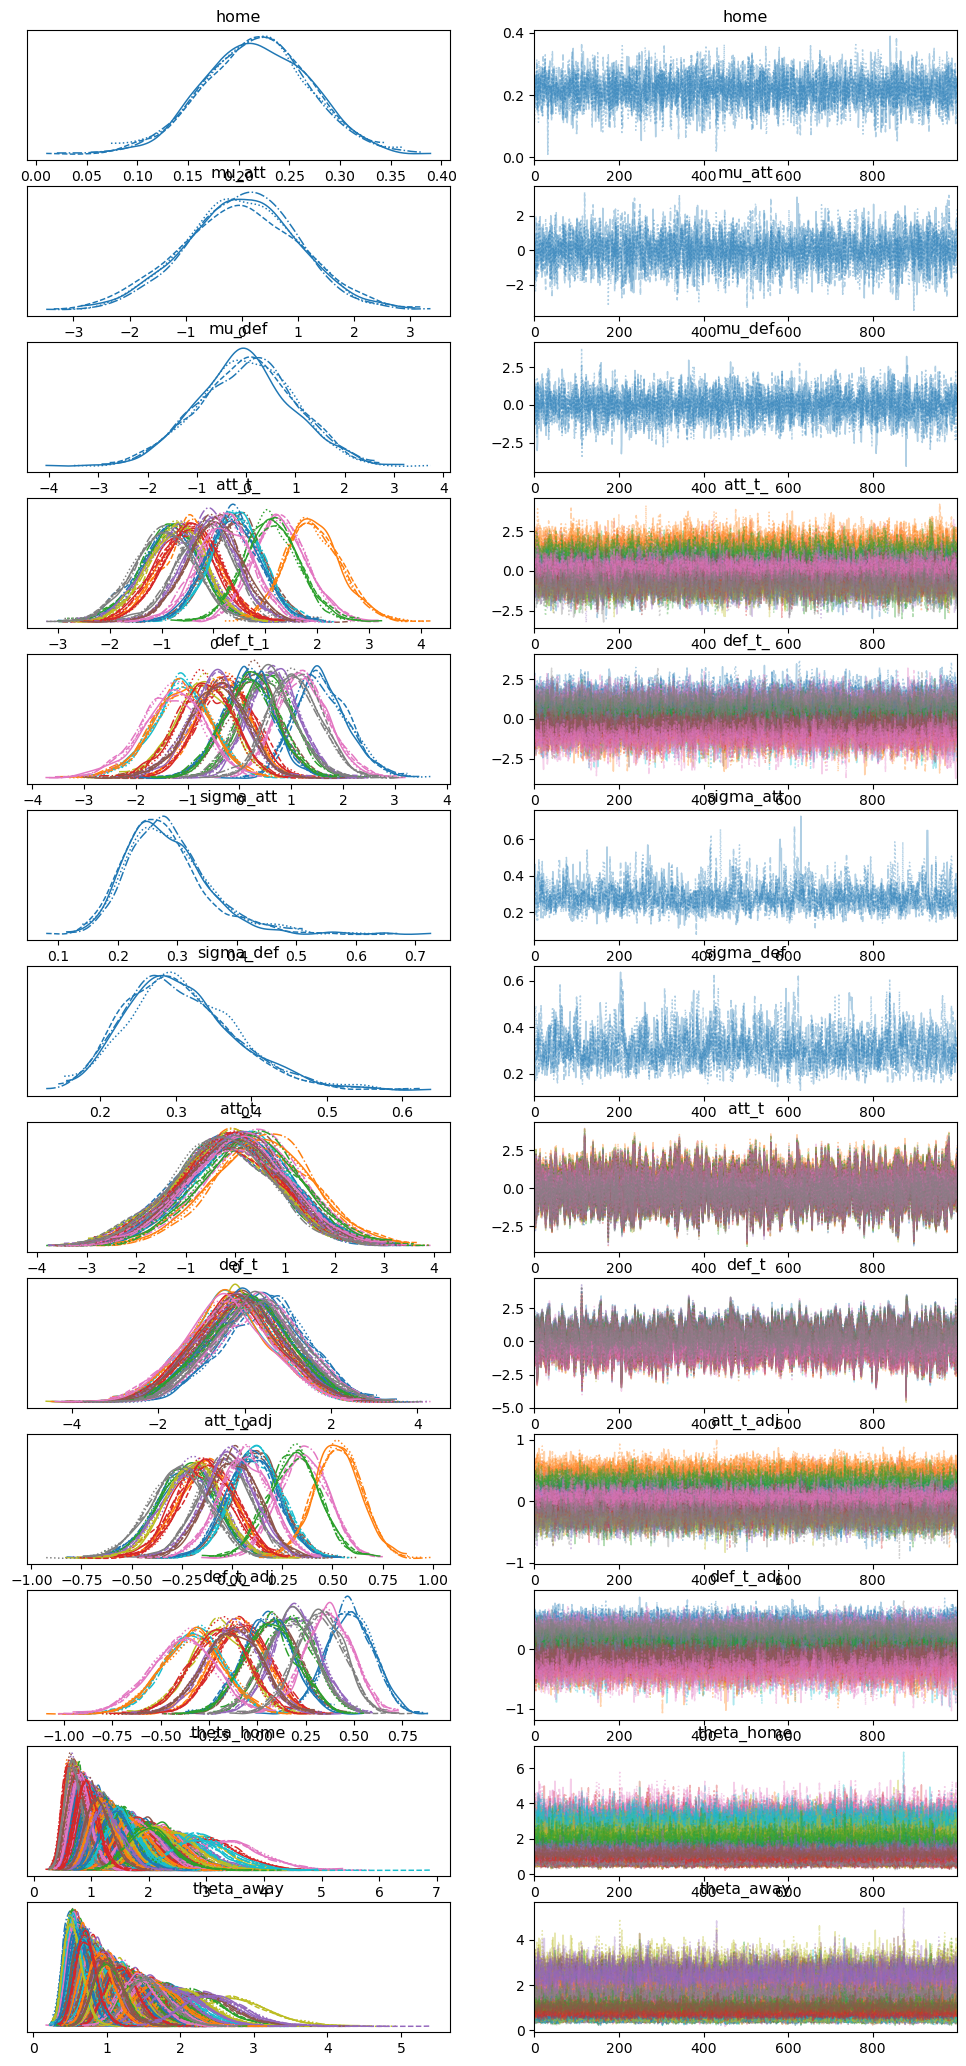

In [35]:
az.plot_trace(idata);

# Model 4 Appraisal
+ Reproduction of original results
+ Calibration

In [36]:
summ_df = az.summary(idata, hdi_prob=0.95).round(2)
summ_df

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
home             0.22  0.05      0.12       0.32       0.00     0.00   
mu_att          -0.01  1.01     -2.09       1.83       0.02     0.02   
mu_def          -0.00  0.98     -1.88       1.92       0.02     0.02   
att_t_[0]       -0.84  0.59     -2.06       0.27       0.01     0.01   
att_t_[1]       -0.48  0.57     -1.62       0.63       0.01     0.01   
...               ...   ...       ...        ...        ...      ...   
theta_away[301]  0.94  0.18      0.62       1.32       0.00     0.00   
theta_away[302]  1.04  0.20      0.66       1.45       0.00     0.00   
theta_away[303]  0.73  0.14      0.47       1.03       0.00     0.00   
theta_away[304]  2.48  0.43      1.67       3.32       0.01     0.00   
theta_away[305]  1.04  0.20      0.68       1.45       0.00     0.00   

                 ess_bulk  ess_tail  r_hat  
home               4750.0    3093.0    1.0  
mu_att             4467.0    2970.0    1.0  
mu_def             4172.0    2794.0    1.0  
att_t_[0]          3609.0    2549.0    1.0  
att_t_[1]          3538.0    3164.0    1.0  
...                   ...       ...    ...  
theta_away[301]    5167.0    2952.0    1.0  
theta_away[302]    5500.0    3094.0    1.0  
theta_away[303]    5577.0    3360.0    1.0  
theta_away[304]    5021.0    3376.0    1.0  
theta_away[305]    4874.0    3327.0    1.0  

[725 rows x 9 columns]

In [37]:
att_rows = summ_df.filter(regex='att_t_adj', axis=0).index.tolist()
atts = summ_df.loc[['home'] + att_rows, ['mean', 'hdi_2.5%', 'hdi_97.5%']]
atts

mean  hdi_2.5%  hdi_97.5%
home           0.22      0.12       0.32
att_t_adj[0]  -0.23     -0.52       0.06
att_t_adj[1]  -0.13     -0.41       0.13
att_t_adj[2]  -0.23     -0.52       0.04
att_t_adj[3]  -0.16     -0.46       0.11
att_t_adj[4]  -0.21     -0.49       0.08
att_t_adj[5]   0.12     -0.12       0.39
att_t_adj[6]   0.35      0.12       0.60
att_t_adj[7]  -0.04     -0.30       0.22
att_t_adj[8]  -0.20     -0.46       0.09
att_t_adj[9]   0.12     -0.12       0.36
att_t_adj[10]  0.10     -0.14       0.35
att_t_adj[11]  0.53      0.30       0.75
att_t_adj[12]  0.31      0.08       0.57
att_t_adj[13] -0.12     -0.38       0.15
att_t_adj[14] -0.02     -0.27       0.24
att_t_adj[15]  0.00     -0.28       0.24
att_t_adj[16]  0.06     -0.21       0.30
att_t_adj[17] -0.27     -0.55       0.03

In [38]:
theta_home_mean_ser = summ_df.filter(regex='theta_home', axis=0)['mean'].rename('theta_home_mean').reset_index(drop=True)
theta_away_mean_ser = summ_df.filter(regex='theta_away', axis=0)['mean'].rename('theta_away_mean').reset_index(drop=True)
df_res = pd.concat([df1, theta_home_mean_ser, theta_away_mean_ser], axis=1)
df_res

g      home        away  hg  ag  yg1  yg2 result  theta_home_mean  \
0      0    Verona        Roma  17  14  0.0  1.0   awin             0.85   
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin             1.56   
2      2     Lazio       Parma  10  13  1.0  1.0   draw             1.15   
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin             1.54   
4      4     Inter      Foggia   8   6  1.0  1.0   draw             1.50   
..   ...       ...         ...  ..  ..  ...  ...    ...              ...   
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw             1.21   
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin             2.04   
303  303     Inter    Atalanta   8   1  0.0  0.0   draw             0.95   
304  304    Foggia       Milan   6  11  2.0  8.0   awin             1.29   
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin             1.14   

     theta_away_mean  
0               1.38  
1               0.96  
2               0.95  
3               0.82  
4               1.18  
..               ...  
301             0.94  
302             1.04  
303             0.73  
304             2.48  
305             1.04  

[306 rows x 10 columns]

In [39]:
# https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/
def win_draw_loss(home_expectation, away_expectation, max_goals=10):
    h = poisson.pmf(range(max_goals+1), home_expectation)
    a = poisson.pmf(range(max_goals+1), away_expectation)    
    m = np.outer(h, a)

    home = np.sum(np.tril(m, -1))
    away = np.sum(np.triu(m, 1))
    draw = np.sum(np.diag(m))

    return home, draw, away

In [40]:
df_res[['p(hwinc)', 'p(drawc)', 'p(awinc)']] = df_res.apply(lambda x: win_draw_loss(x.theta_home_mean, x.theta_away_mean),
                                                         axis=1, result_type='expand')
df_res = pd.concat([df_res, pd.get_dummies(df_res['result'])], axis=1)
df_res

g      home        away  hg  ag  yg1  yg2 result  theta_home_mean  \
0      0    Verona        Roma  17  14  0.0  1.0   awin             0.85   
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin             1.56   
2      2     Lazio       Parma  10  13  1.0  1.0   draw             1.15   
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin             1.54   
4      4     Inter      Foggia   8   6  1.0  1.0   draw             1.50   
..   ...       ...         ...  ..  ..  ...  ...    ...              ...   
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw             1.21   
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin             2.04   
303  303     Inter    Atalanta   8   1  0.0  0.0   draw             0.95   
304  304    Foggia       Milan   6  11  2.0  8.0   awin             1.29   
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin             1.14   

     theta_away_mean  p(hwinc)  p(drawc)  p(awinc)  awin  draw  hwin  
0               1.38  0.231154  0.275838  0.493007     1     0     0  
1               0.96  0.513132  0.254323  0.232544     0     0     1  
2               0.95  0.402467  0.297532  0.300001     0     1     0  
3               0.82  0.543349  0.257016  0.199634     0     0     1  
4               1.18  0.445947  0.255437  0.298615     0     1     0  
..               ...       ...       ...       ...   ...   ...   ...  
301             0.94  0.422502  0.291762  0.285736     0     1     0  
302             1.04  0.604635  0.209138  0.186217     0     0     1  
303             0.73  0.391705  0.339837  0.268458     0     1     0  
304             2.48  0.184143  0.181531  0.634269     1     0     0  
305             1.04  0.379042  0.292427  0.328531     1     0     0  

[306 rows x 16 columns]

In [41]:
dfc = df_res.copy()
n_bins = 10
strategy='quantile'
n_matches = len(dfc)
cal_df = make_1x2_calib_data(dfc, n_bins=n_bins, strategy=strategy, error_bar_alpha=0.05)
cal_df.head()

bin_num  mean_predicted_proba  mean_actual_proba  bin_count  prob_pred  \
0        0              0.184029           0.000000         31   0.184029   
1        1              0.262879           0.258065         31   0.262879   
2        2              0.310437           0.300000         30   0.310437   
3        3              0.361180           0.322581         31   0.361180   
4        4              0.396399           0.366667         30   0.396399   

   bin_count   2.5%_CI  97.5%_CI calib  
0         31  0.047619  0.320439  hwin  
1         31  0.107921  0.417837  hwin  
2         30  0.144875  0.475999  hwin  
3         31  0.192090  0.530271  hwin  
4         30  0.221362  0.571435  hwin

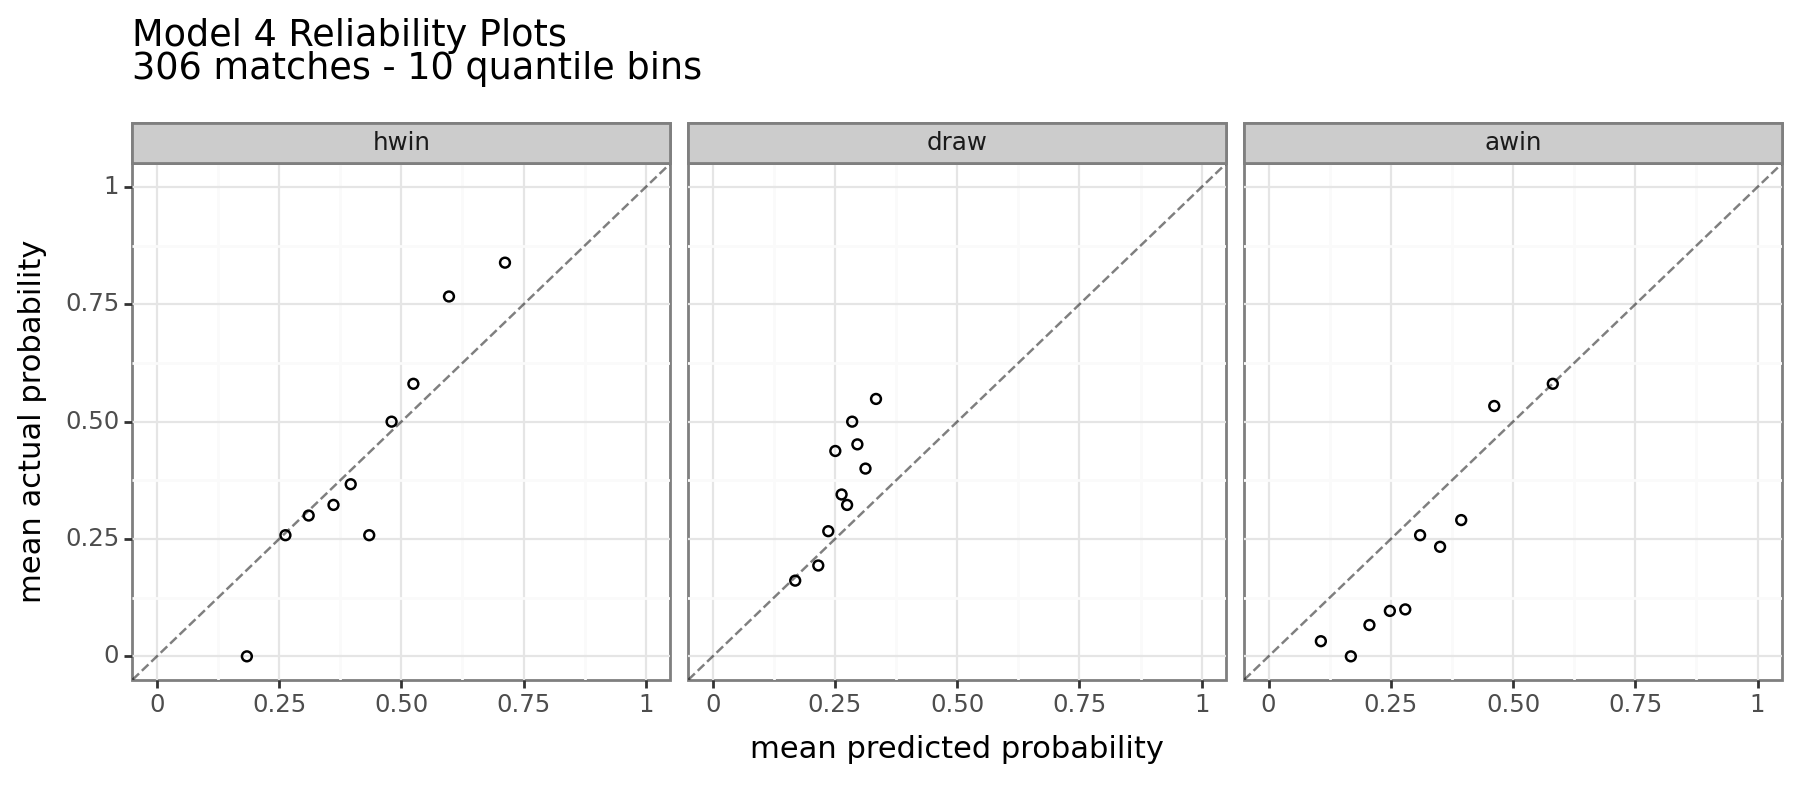

In [42]:
p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
     geom_point(fill='none') +
     # geom_errorbarh(aes(xmin='2.5%_CI', xmax='97.5%_CI'), height=0.025, alpha=0.3) +
     geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
     coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
     labs(x='mean predicted probability',
          y='mean actual probability',
          title=f'Model 4 Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
     facet_wrap('calib') +
     theme(figure_size=(9,4))
    )
plt.close()
p.draw()

Changes to make a hierarchical model non-centred

with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)


# Resources
+ [Bayesian hierarchical model for the prediction of football results (pdf) - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ [Predicting Football Results Using Bayesian Modelling with Python and PyMC3 (webpage) -  Martin Eastwood - pena.lt/y blog](https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/)
+ [Hierarchical Modelling in Stan: Predicting the Premier League (YouTube video & associated material) -  Maggie Lieu - Stan Youtube channel](https://www.youtube.com/watch?v=dNZQrcAjgXQ&list=PLdw9iy95A5dh9tr3ZEiPICRYu8geqi9N9&index=103)
+ [Why hierarchical models are awesome, tricky, and Bayesian (webpage) - Thomas Wiecki - twiecki.io website](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
+ [Diagnosing Biased Inference with Divergences (webpage) - pymc documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
+ [Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results (github repository) - liotti2085 - github](https://github.com/liotti2085/Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results/tree/main)
+ Data Sources
    + [Italy Serie A 1992-1993](https://fbref.com/en/comps/11/1992-1993/schedule/1992-1993-Serie-A-Scores-and-Fixtures) from fbref.com
    + [Italy Serie A 2007-2008](https://www.football-data.co.uk/italym.php) from football-data.co.uk
    + [Fixture Download website](https://fixturedownload.com/) includes future fixtures

## Original winBUGS code
```
model {
# LIKELIHOOD AND RANDOM EFFECT MODEL FOR THE SCORING PROPENSITY
for (g in 1:ngames) {
# Observed number of goals scored by each team
y1[g] ~ dpois(theta[g,1])
y2[g] ~ dpois(theta[g,2])
# Predictive distribution for the number of goals scored
ynew[g,1] ~ dpois(theta[g,1])
ynew[g,2] ~ dpois(theta[g,2])
# Average Scoring intensities (accounting for mixing components)
log(theta[g,1]) <- home + att[hometeam[g]] + def[awayteam[g]]
log(theta[g,2]) <- att[awayteam[g]] + def[hometeam[g]]
}
# 1. BASIC MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Trick to code the ‘‘sum-to-zero’’ constraint
for (t in 1:nteams){
att.star[t] ~ dnorm(mu.att,tau.att)
def.star[t] ~ dnorm(mu.def,tau.def)
att[t] <- att.star[t] - mean(att.star[])
def[t] <- def.star[t] - mean(def.star[])
}
# priors on the random effects
mu.att ~ dnorm(0,0.0001)
mu.def ~ dnorm(0,0.0001)
tau.att ~ dgamma(.01,.01)
tau.def ~ dgamma(.01,.01)
# 2. MIXTURE MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Mixture parameters & components (‘‘sum-to-zero’’ constraint)
for (t in 1:nteams){
grp.att[t] ~ dcat(p.att[t,])
grp.def[t] ~ dcat(p.def[t,])
att[t] ~ dt(mu.att[grp.att[t]],tau.att[grp.att[t]],4)
def[t] ~ dt(mu.def[grp.def[t]],tau.def[grp.def[t]],4)
att.star[t] <- att[t] - mean(att[])
def.star[t] <- def[t] - mean(def[])
# Priors on the mixture parameter (team specific)
p.att[t,1:3] ~ ddirch(prior.att[t,])
p.def[t,1:3] ~ ddirch(prior.def[t,])
}
# Priors on the random effects
# group 1: bottom-table teams
mu.att[1] ~ djl.dnorm.trunc(0,0.001,-3,0)
mu.def[1] ~ djl.dnorm.trunc(0,0.001,0,3)
tau.att[1] ~ dgamma(0.01,0.01)
tau.def[1] ~ dgamma(0.01,0.01)
# group 2: mid-table teams
mu.att[2] <-0
mu.def[2] <-0
tau.att[2] ~ dgamma(0.01,0.01)
tau.def[2] ~ dgamma(0.01,0.01)
# group 3: top-table teams
mu.att[3] ~ djl.dnorm.trunc(0,0.001,0,3)
mu.def[3] ~ djl.dnorm.trunc(0,0.001,-3,0)
tau.att[3] ~ dgamma(0.01,0.01)
tau.def[3] ~ dgamma(0.01,0.01)
}
```